# Applying the BERT, LSTMS AND RNN on our Data

In [1]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import nltk
import string
from nltk.corpus import stopwords 
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#from sklearn.feature_extraction.text import TfidfVectorizerb
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from transformers import BertTokenizer, TFBertModel
from sklearn.metrics import classification_report, confusion_matrix
# Import Libraries

import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#from keras.preprocessing.sequence import pad_sequences
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#ls

In [4]:
df = pd.read_csv("C:/Users/dell/Desktop/Dessertation MS KG/Pakistan (1)/Cases in Pakistan and in India  updated.xlsx - Sheet1.csv",encoding= 'unicode_escape')
df

,article,label
0,"Informal labourers, who are in severe debt due...",0
1,NEW DELHI (Thomson Reuters Foundation) - The c...,1
2,"Reporting from Mumbai, India Seven years aft...",2
3,Police in Pakistan said Friday they busted an ...,2
4,The gang's victims were taken to a medical tes...,2
5,Illegal kidney trade in the country recently c...,1
6,"For a hospital, this centre for kidney transpl...",1
7,"In 2002, Kenam Tamang was duped into parting w...",1
8,LAHORE: A family on Monday lodged a complaint ...,1
9,LAHORE: The Federal Investigation Agency (FIA)...,2


In [5]:
#!pip install keras_preprocessing
#!pip install pytorch_pretrained_bert
#!pip install transformers

In [6]:
# Split data into train and test sets
train_data, test_data = train_test_split(df, test_size=0.20)

In [7]:
# Use TF-IDF to extract features
vectorizer = TfidfVectorizer()
train_features = vectorizer.fit_transform(train_data['article'])
test_features = vectorizer.transform(test_data['article'])

test_features
train_features

<12x3202 sparse matrix of type '<class 'numpy.float64'>'
	with 6000 stored elements in Compressed Sparse Row format>

In [8]:
sentences = df.article.values
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case = True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

In [9]:
MAX_LEN = 300

In [10]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (1314 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (542 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (2235 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (567 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (5807 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence lengt

In [11]:
input_ids = pad_sequences(input_ids,maxlen= MAX_LEN,dtype="long", truncating="post",padding="post")
input_ids

array([[  101, 11900, 24043, ...,  2005,  2122, 14234],
       [  101,  2047,  6768, ..., 15843,  1997, 11595],
       [  101,  7316,  2013, ...,  2007,  4678, 11790],
       ...,
       [  101,  8811,  2197, ...,  2007,  2010,  2564],
       [  101,  2169,  2095, ...,  1010,  1045,  8143],
       [  101, 15036,  1024, ...,  2409,  6440,  2044]])

In [12]:
#creating attention mask
attention_masks = []
#creating masks for the 1's and followed by 0's padding 
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [14]:
#attention_masks

In [17]:
train_inputs,validation_inputs,train_labels,validation_labels = train_test_split(input_ids, labels,  random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [18]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [19]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [20]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

In [22]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [{'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],'weight_decay_rate': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],'weight_decay_rate': 0.0}]

In [23]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,lr=2e-5,warmup=.1)

t_total value of -1 results in schedule not being applied


In [24]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [25]:
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs 
epochs = 2

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    # batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    # batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]D:\Users\dell\anaconda3\lib\site-packages\pytorch_pretrained_bert\optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\python_arg_parser.cpp:1485.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 1.008774995803833


Epoch:  50%|█████     | 1/2 [00:26<00:26, 26.97s/it]

Validation Accuracy: 0.0
Train loss: 1.0029152631759644


Epoch: 100%|██████████| 2/2 [00:49<00:00, 24.52s/it]

Validation Accuracy: 0.5


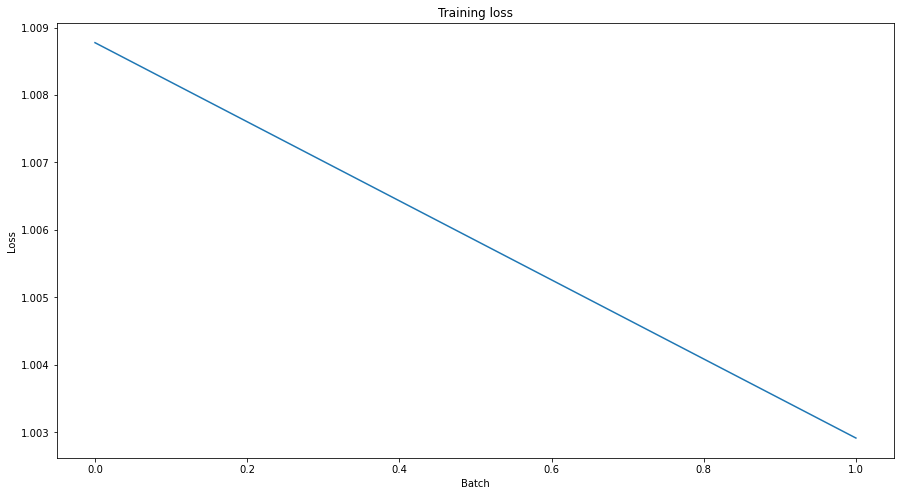

In [26]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [48]:
# Create sentence and label lists
sentences = df.article.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (1314 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (542 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (2235 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (567 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (5807 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence lengt

In [49]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
 # batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [50]:
 #Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

In [51]:
matthews_set

[0.7859470148069994]